In [1]:
from valurap import printer, commands
import imp
imp.reload(commands)
imp.reload(printer)

from math import sqrt
from valurap.asg import Asg, ProfileSegment, PathSegment

%matplotlib inline
import pandas as pd

class ApgState(object):
    def __init__(self):
        self.x = 0
        self.v = 0
        self.a = 0
        self.j = 0
        self.jj = 0
        self.target_v = 0
        self.target_v_set = False
        
    def load(self, seg):
        if seg.x is not None:
            self.x = seg.x * 2**32
        if seg.v is not None:
            self.v = seg.v
        if seg.a is not None:
            self.a = seg.a
        if seg.j is not None:
            self.j = seg.j
        if seg.jj is not None:
            self.jj = seg.jj
        if seg.target_v is not None:
            self.target_v = seg.target_v
            self.target_v_set = True
        else:
            self.target_v_set = False
            
    def step(self):
        next_x = self.x + self.v * 50000
        next_v = int(self.v + (self.a / 65536))
        next_a = self.a + self.j
        next_j = self.j + self.jj
        next_jj = self.jj
        if self.target_v_set:
            if self.v == self.target_v:
                next_jj = 0
                next_j = 0
                next_a = 0
                next_v = self.target_v
            elif ((self.v < self.target_v and next_v > self.target_v) or 
                  (self.v > self.target_v and next_v < self.target_v)):
                next_jj = 0
                next_j = 0
                next_v = self.target_v
                next_a = (self.target_v - self.v) * 65536
             
        #effective_v = (self.v + next_v) / 2
        effective_v = next_v

        self.x = next_x
        self.v = next_v
        self.a = next_a
        self.j = next_j
        self.jj = next_jj
        
    
def emulate(profile, verbose=False):
    apg_states = {
        "X": ApgState(),
        "Y": ApgState(),
        "Z": ApgState()
    }
    ts = 0
    steps = {}
    for dt, segs in profile:
        print(dt)
        ts_start = ts
        ts += dt
        for seg in segs:
            print("  ",seg)
            state = apg_states[seg.apg.name]
            state.load(seg)
            prefix = seg.apg.name + "_"
            
            if not verbose:
                print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start, state.x / 2.0**32, state.v, state.a))
                print("                 ...")

            last_v = None
            first_v = 0
            for i in range(dt):
                step_data = steps.setdefault(ts_start + i, {'ts': ts_start + i})
                step_data[prefix + "jj"] = state.jj
                step_data[prefix + "j"] = state.j
                step_data[prefix + "a"] = state.a
                step_data[prefix + "v"] = state.v/65536
                step_data[prefix + "x"] = state.x/2**32

                if state.v != last_v:
                    if verbose:
                        if first_v > 0:
                            if first_v > 1:
                                print("        ... {} ...".format(first_v - 1))
                            print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i - 1, prev_x / 2.0**32, prev_v, prev_a))
                        print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i, state.x / 2.0**32, state.v, state.a))
                    last_v = state.v
                    first_v = 0
                else:
                    if not verbose and first_v == 0:
                        print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i - 1, prev_x / 2.0**32, prev_v, prev_a))

                    first_v += 1
                    
                prev_x = state.x
                prev_v = state.v
                prev_a = state.a
                state.step()

            if verbose:
                if first_v != 0:
                    if first_v > 1:
                        print("           ... {} ...".format(first_v - 1))
                    print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i, state.x / 2.0**32, state.v, state.a))
            else:
                if first_v > 1:
                    print("                 ...")

                print("    {:6d} {:10.3f} {:10.1f} {:10.1f}".format(ts_start + i, state.x / 2.0**32, state.v, state.a))
            

    steps = [a[1] for a in sorted(steps.items())]
    steps = pd.DataFrame(steps)
    return steps
                
p = printer.Valurap()
    
p.axes["X1"].apg = p.apgs["X"]
p.axes["X2"].apg = p.apgs["Y"]
p.axes["Y"].apg = p.apgs["Z"]

428
   <ProfileSegment apg=Z v=0 a=0 j=9750212 jj=-68423 target_v=2006994>
         0      0.000        0.0        0.0
                 ...
         0      0.000        0.0        0.0
       267   2916.380  2006994.0 111017984.0
                 ...
       427   6678.062  2006994.0        0.0
285
   <ProfileSegment apg=Z a=0 j=-9750212 jj=68423 target_v=0>
       428   6678.062  2006994.0        0.0
                 ...
       428   6678.062  2006994.0        0.0
       695   9999.589        0.0 -93650944.0
                 ...
       712   9999.589        0.0        0.0
10
   <ProfileSegment apg=Z v=0 a=0 j=0 jj=0>
       713   9999.589        0.0        0.0
                 ...
       713   9999.589        0.0        0.0
                 ...
       722   9999.589        0.0        0.0


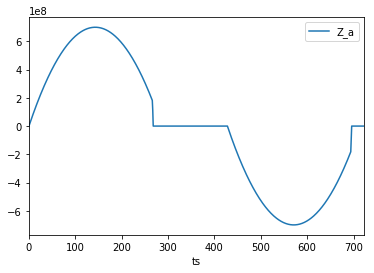

In [2]:
pr = p.plan_move(Y=10000)

steps = emulate(pr, False)
steps.plot(x = "ts", y = ["Z_a"])

In [44]:
from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment


def solve_model_simple(in_v, target_plato_v, target_out_v, target_x, accel_t, 
                plato_t, decel_t, max_a = 20000, min_delta_v=100):
    
    vtoa_k = 65536
    xtov_k = 2**32 / 50000
    xtoa_k = vtoa_k * xtov_k

    def ir(x):
        return int(round(x))
    
    def int_x(t, v, a, j, jj):
        return ir(v * t + a*t*(t-1)/2 + j*t*(t-1)*(t-2)/6 + jj*t*(t-1)*(t-2)*(t-3)/24)

    def int_v(t, v, a, j, jj):
        return ir(v + a * t + j*t*(t-1)/2 + jj*t*(t-1)*(t-2)/6)


    accel_a = (target_plato_v - in_v) / accel_t * vtoa_k * 1.5
    accel_j = accel_a / accel_t * 2 * 2
    accel_jj = -accel_j / accel_t * 2
    
    print("accel_a:", accel_a)
    print("accel_j:", accel_j)
    print("accel_jj:", accel_jj)
    
    int_accel_jj = ir(accel_jj)
    int_accel_j = ir(-int_accel_jj * accel_t / 2)
    print("int_accel_j:", int_accel_j)
    print("int_accel_jj:", int_accel_jj)
    
    int_accel_x = int_x(accel_t, in_v * vtoa_k, 0, int_accel_j, int_accel_jj)
    int_accel_v = int_v(accel_t, in_v * vtoa_k, 0, int_accel_j, int_accel_jj)
    

    decel_a = (target_out_v - target_plato_v) / decel_t * vtoa_k * 1.5
    decel_j = decel_a / decel_t * 2 * 2
    decel_jj = -decel_j / decel_t * 2
    
    int_decel_jj = ir(decel_jj)
    int_decel_j = ir(-int_decel_jj * decel_t / 2)
    
    int_decel_x = int_x(decel_t, target_plato_v * vtoa_k, 0, int_decel_j, int_decel_jj)
    int_decel_v = int_v(decel_t, target_plato_v * vtoa_k, 0, int_decel_j, int_decel_jj)


    plato_x = target_x * xtoa_k - int_accel_x - int_decel_x
    plato_v = plato_x / plato_t
    
    int_plato_v = ir(plato_v)
    int_plato_x = int_x(plato_t, int_plato_v, 0, 0, 0)
    
    return {
        "accel_j": int_accel_j,
        "accel_jj": int_accel_jj,
        "plato_v": int_plato_v/vtoa_k,
        "decel_j": int_decel_j,
        "decel_jj": int_decel_jj,
        "accel_x": int_accel_x/xtoa_k,
        "plato_x": int_plato_x/xtoa_k,
        "decel_x": int_decel_x/xtoa_k,
    }


p = printer.Valurap()
apg_x = p.apgs["X"]
apg_y = p.apgs["Y"]
apg_z = p.apgs["Z"]

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10

 
path_deltas = []
l = 100
v = 100

for i in range(0, 10):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v])
    

path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
    
print(path)

max_a = array([3000.0, 3000.0])

pr = []
pr_opt = []

in_x = array([0,0])
in_target = array([0,0])
in_v = array([0,0])
in_avail = array([0,0])

for i, seg in enumerate(path):
    target_x, target_y, target_v = seg
    
    cur_target = array([target_x, target_y])
    
    cur_d = cur_target - in_target
    assert(norm(cur_d) > 0)
    assert(target_v > 0)
    
    if i == len(path) - 1:
        out_v = array([0, 0])
        out_avail = array([0, 0])
    else:
        next_x, next_y, next_v = path[i+1]
        next_target = array([next_x, next_y])
        next_d = next_target - cur_target
        assert(norm(next_d) > 0)
        
        out_v = next_v * next_d / norm(next_d)
        out_avail = next_d / 2

    cur_avail = cur_d
    plato_v = target_v * cur_d / norm(cur_d)
    
    print("speeds:", in_v, plato_v, out_v)
    print("avails:", in_avail, cur_avail, out_avail)

    # Enter
    enter_delta_v = plato_v - in_v
    print("enter_delta_v:", enter_delta_v)
    
    enter_time = max(list(absolute(enter_delta_v) / max_a))
    print("enter_time:", enter_time)
    
    enter_a = enter_delta_v / enter_time
    print("enter_a:", enter_a)
    enter_speed_filter = absolute(enter_delta_v) > 0.1

    enter_delta_x = in_v * enter_time + enter_a * enter_time**2 / 2
    print("enter_delta_x:", enter_delta_x)
    
    enter_t_first = (enter_time * plato_v[enter_speed_filter] - enter_delta_x[enter_speed_filter]) / enter_delta_v[enter_speed_filter]
    enter_t_second = enter_time - enter_t_first
    print("enter_t_first:", enter_t_first)
    print("enter_t_second:", enter_t_second)
    assert((enter_t_first >= 0).all())
    assert((enter_t_second >= 0).all())
    
    enter_need_first = in_v[enter_speed_filter] * enter_t_first
    enter_need_second = plato_v[enter_speed_filter] * enter_t_second
    print("enter_need_first:", enter_need_first)
    print("enter_need_second:", enter_need_second)
    enter_need_first_filter = absolute(enter_need_first) > 0.01
    enter_need_second_filter = absolute(enter_need_second) > 0.01
    assert((in_avail[enter_speed_filter][enter_need_first_filter]/enter_need_first[enter_need_first_filter] > 1.0).all())
    assert((cur_avail[enter_speed_filter][enter_need_second_filter]/enter_need_second[enter_need_second_filter] > 2.0).all())
    cur_avail[enter_speed_filter] = cur_avail[enter_speed_filter] - enter_need_second
        
    # Exit
    exit_delta_v = out_v - plato_v
    print("exit_delta_v:", exit_delta_v)

    exit_time = max(list(absolute(exit_delta_v) / max_a))
    print("exit_time:", exit_time)

    exit_a = exit_delta_v / exit_time
    print("exit_a:", exit_a)
    exit_speed_filter = absolute(exit_delta_v) > 0.1

    exit_delta_x = plato_v * exit_time + exit_a * exit_time**2 / 2
    print("exit_delta_x:", exit_delta_x)

    exit_t_first = (exit_time * out_v[exit_speed_filter] - exit_delta_x[exit_speed_filter]) / exit_delta_v[exit_speed_filter]
    exit_t_second = exit_time - exit_t_first
    
    print("exit_t_first:", exit_t_first)
    print("exit_t_second:", exit_t_second)
    assert((exit_t_first >= 0).all())
    assert((exit_t_second >= 0).all())

    exit_need_first = plato_v[exit_speed_filter] * exit_t_first 
    exit_need_second = out_v[exit_speed_filter] * exit_t_second
    print("exit_need_first:", exit_need_first)
    print("exit_need_second:", exit_need_second)
    exit_need_first_filter = absolute(exit_need_first) > 0.01
    exit_need_second_filter = absolute(exit_need_second) > 0.01
    #print("exit_first_filter:", exit_first_filter)
    #print("exit_second_filter:", exit_second_filter)
    assert(((cur_avail[exit_speed_filter][exit_need_first_filter]/exit_need_first[exit_need_first_filter]) > 1.0).all())
    assert(((out_avail[exit_speed_filter][exit_need_second_filter]/exit_need_second[exit_need_second_filter]) > 2.0).all())

    
    if norm(in_v) > 0:
        # remaining path from first step from end of last accel to start of new accel
        # performing with constant speed
        #  remaining path
        prev_plato = (in_target - in_x)
        prev_plato[enter_speed_filter] -= enter_need_first
        #  required time in ms
        prev_t = int(round(1000 * norm(prev_plato) / norm(in_v)))

        #  recalcalcalculated speed (possible with small jerk)
        prev_v = prev_plato / (prev_t / 1000)
        prev_v_x = int(round(prev_v[0] * 80 * 2**32 / 50000000))
        prev_v_y = int(round(prev_v[1] * 80 * 2**32 / 50000000))

        print("prev_plato_jerk:", in_v - prev_v)
        #new accel start point
        accel_start = in_x + array([prev_v_x, prev_v_y]) * prev_t / (80 * 2**32 / 50000000) / 1000
    else:
        prev_t = 0
        prev_v = in_v
        accel_start = in_x
    
    
    # new decel finish_point
    print("cur_target:", cur_target)
    decel_end = cur_target 
    decel_end[exit_speed_filter] += exit_need_second
    print("decel_end:", decel_end)
    
    plato_t = int(round(1000 * (norm(cur_d)/norm(plato_v) - enter_t_second[0] - exit_t_first[0] )))
    accel_t = int(round(1000 * (enter_t_first[0] + enter_t_second[0])))
    decel_t = int(round(1000 * (exit_t_first[0] + exit_t_second[0])))

    print("accel_start:", accel_start)
    target_x = decel_end - accel_start
    print("target_x:", target_x)
    
    args_x = dict(
        in_v=int(round(prev_v[0] * 80 * 2**32 / 50000000)),
        target_plato_v=int(round(plato_v[0] * 80 * 2**32 / 50000000)),
        target_out_v=int(round(out_v[0] * 80 * 2**32 / 50000000)),
        target_x=int(round(target_x[0] * 80)),
        accel_t=accel_t,
        plato_t=plato_t, 
        decel_t=decel_t,
        max_a = 200000,
        min_delta_v=500
    )
    n = 10
    print("args_x:", args_x)
    while n > 0:
        solution_x = solve_model_simple(**args_x)
        if solution_x:
            break
        args_x["min_delta_v"] *= 5
        n -= 1
    assert(solution_x)

    args_y = dict(
        in_v=int(round(prev_v[1] * 80 * 2**32 / 50000000)),
        target_plato_v=int(round(plato_v[1] * 80 * 2**32 / 50000000)),
        target_out_v=int(round(out_v[1] * 80 * 2**32 / 50000000)),
        target_x=int(round(target_x[1] * 80)),
        accel_t=accel_t,
        plato_t=plato_t, 
        decel_t=decel_t,
        max_a = 200000,
        min_delta_v=500
    )

    n = 10
    print("args_y:", args_y)
    while n > 0:
        solution_y = solve_model_simple(**args_y)
        if solution_y:
            break
        args_y["min_delta_v"] *= 5
        n -= 1

    assert(solution_x)
    print("sol_x:", solution_x)
    print("sol_y:", solution_y)
    if prev_t > 0:
        pr_opt += [
            [int(round(prev_t)), [
                ProfileSegment(apg=apg_x, v = prev_v_x),
                ProfileSegment(apg=apg_y, v = prev_v_y),
                ProfileSegment(apg=apg_z, v=-400000),
            ]]
        ]

    pr_opt += [
        [accel_t, [
            ProfileSegment(apg=apg_x, j=solution_x["accel_j"], jj=solution_x["accel_jj"]),
            ProfileSegment(apg=apg_y, j=solution_y["accel_j"], jj=solution_y["accel_jj"]),
            ProfileSegment(apg=apg_z, v=-400000),
        ]]
    ]
                       
    if i == len(path) - 1:
        pr_opt += [
            [plato_t, [
                ProfileSegment(apg=apg_x, v = solution_x["plato_v"]),
                ProfileSegment(apg=apg_y, v = solution_y["plato_v"]),
                ProfileSegment(apg=apg_z, v=-400000),
            ]],
            [decel_t, [
                ProfileSegment(apg=apg_x, j=solution_x["decel_j"], jj=solution_x["decel_jj"]),
                ProfileSegment(apg=apg_y, j=solution_y["decel_j"], jj=solution_y["decel_jj"]),
                ProfileSegment(apg=apg_z, v=-400000),
            ]],
            [5, [
                ProfileSegment(apg=apg_x, v=0),
                ProfileSegment(apg=apg_y, v=0),
                ProfileSegment(apg=apg_z, v=0),
                
            ]]

        ]

    print("i:", i)
    plato_v = array([solution_x["plato_v"], solution_y["plato_v"]])/(80.0 * 2**32 / 50000000)

    
    print()
    in_v = plato_v
    in_target = cur_target
    in_x = accel_start + array([solution_x["accel_x"], solution_y["accel_x"]]) / 80
    in_avail = in_target - in_x

%matplotlib notebook
    
import warnings
warnings.filterwarnings("error")

steps_opt = emulate(pr_opt, False)
steps_opt = pd.DataFrame(steps_opt)




[[200.0, 0, 100], [200.0, -200.0, 100], [2.5, -200.0, 100], [2.5, -2.5, 100], [197.5, -2.5, 100], [197.5, -197.5, 100], [5.0, -197.5, 100], [5.0, -5.0, 100], [195.0, -5.0, 100], [195.0, -195.0, 100], [7.5, -195.0, 100], [7.5, -7.5, 100], [192.5, -7.5, 100], [192.5, -192.5, 100], [10.0, -192.5, 100], [10.0, -10.0, 100], [190.0, -10.0, 100], [190.0, -190.0, 100], [12.5, -190.0, 100], [12.5, -12.5, 100], [187.5, -12.5, 100], [187.5, -187.5, 100], [15.0, -187.5, 100], [15.0, -15.0, 100], [185.0, -15.0, 100], [185.0, -185.0, 100], [17.5, -185.0, 100], [17.5, -17.5, 100], [182.5, -17.5, 100], [182.5, -182.5, 100], [20.0, -182.5, 100], [20.0, -20.0, 100], [180.0, -20.0, 100], [180.0, -180.0, 100], [22.5, -180.0, 100], [22.5, -22.5, 100], [177.5, -22.5, 100], [177.5, -177.5, 100], [25.0, -177.5, 100], [25.0, -25.0, 100]]
speeds: [0 0] [100.   0.] [   0. -100.]
avails: [0 0] [200.   0.] [   0. -100.]
enter_delta_v: [100.   0.]
enter_time: 0.03333333333333333
enter_a: [3000.    0.]
enter_delta_x

int_accel_jj: -13621237
args_y: {'in_v': 693391, 'target_plato_v': 0, 'target_out_v': -687195, 'target_x': 2, 'accel_t': 34, 'plato_t': 1783, 'decel_t': 33, 'max_a': 200000, 'min_delta_v': 500}
accel_a: -2004797319.5294118
accel_j: -235858508.1799308
accel_jj: 13874029.892937107
int_accel_j: -235858510
int_accel_jj: 13874030
sol_x: {'accel_j': 231561029, 'accel_jj': -13621237, 'plato_v': 693635.7532043457, 'decel_j': -248132296, 'decel_jj': 15038321, 'accel_x': 136.47891999397643, 'plato_x': 14397.694589143483, 'decel_x': 132.82649087358323}
sol_y: {'accel_j': -235858510, 'accel_jj': 13874030, 'plato_v': -234.26861572265625, 'decel_j': -248132296, 'decel_jj': 15038321, 'accel_x': 138.03627734603197, 'plato_x': -4.862678957096023, 'decel_x': -131.17359849985633}
i: 12

speeds: [ 1.00937287e+02 -3.40905704e-02] [   0. -100.] [-100.    0.]
avails: [181.62801017  -1.69439243] [   0.         -183.33333333] [-91.25   0.  ]
enter_delta_v: [-100.9372868   -99.96590943]
enter_time: 0.0336457622

enter_need_second: [0.         1.68345397]
exit_delta_v: [ 100. -100.]
exit_time: 0.03333333333333334
exit_a: [ 3000. -3000.]
exit_delta_x: [1.66666667 1.66666667]
exit_t_first: [0.01666667 0.01666667]
exit_t_second: [0.01666667 0.01666667]
exit_need_first: [0.         1.66666667]
exit_need_second: [1.66666667 0.        ]
prev_plato_jerk: [-0.02645829 -0.99119981]
cur_target: [ 15. -15.]
decel_end: [ 16.66666667 -15.        ]
accel_start: [  16.70032194 -185.83388185]
target_x: [-3.36552712e-02  1.70833882e+02]
args_x: {'in_v': -693935, 'target_plato_v': 0, 'target_out_v': 687195, 'target_x': -3, 'accel_t': 34, 'plato_t': 1658, 'decel_t': 33, 'max_a': 200000, 'min_delta_v': 500}
accel_a: 2006370183.5294118
accel_j: 236043551.0034602
accel_jj: -13884914.764909424
int_accel_j: 236043555
int_accel_jj: -13884915
args_y: {'in_v': 7016, 'target_plato_v': 687195, 'target_out_v': 0, 'target_x': 13667, 'accel_t': 34, 'plato_t': 1658, 'decel_t': 33, 'max_a': 200000, 'min_delta_v': 500}
accel_a: 

exit_t_second: [0.01666667 0.01666667]
exit_need_first: [-1.66666667  0.        ]
exit_need_second: [0.         1.66666667]
prev_plato_jerk: [ 1.06992411 -0.03024256]
cur_target: [  22.5 -180. ]
decel_end: [  22.5        -178.33333333]
accel_start: [ 178.33387205 -178.29695888]
target_x: [-1.55833872e+02 -3.63744579e-02]
args_x: {'in_v': -7581, 'target_plato_v': -687195, 'target_out_v': 0, 'target_x': -12467, 'accel_t': 34, 'plato_t': 1508, 'decel_t': 33, 'max_a': 200000, 'min_delta_v': 500}
accel_a: -1964963960.4705882
accel_j: -231172230.64359862
accel_jj: 13598366.508446977
int_accel_j: -231172239
int_accel_jj: 13598367
args_y: {'in_v': -694466, 'target_plato_v': 0, 'target_out_v': 687195, 'target_x': -3, 'accel_t': 34, 'plato_t': 1508, 'decel_t': 33, 'max_a': 200000, 'min_delta_v': 500}
accel_a: 2007905460.7058823
accel_j: 236224171.84775087
accel_jj: -13895539.520455934
int_accel_j: 236224180
int_accel_jj: -13895540
sol_x: {'accel_j': -231172239, 'accel_jj': 13598367, 'plato_v': -

                 ...
      1982   -133.323    -5873.0        0.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
        33   -153.668  -400000.0        0.0
                 ...
        33   -153.668  -400000.0        0.0
                 ...
      1982  -9234.063  -400000.0        0.0
34
   <ProfileSegment apg=X a=0 j=-235746259 jj=13867427>
      1983  15864.340   693061.0        0.0
                 ...
      1983  15864.340   693061.0        0.0
      2016  16002.307   -58768.0 -235746259.0
   <ProfileSegment apg=Y a=0 j=-231753214 jj=13632542>
      1983   -133.323    -5873.0        0.0
                 ...
      1983   -133.323    -5873.0        0.0
      2016   -269.687  -744939.0 -231753214.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
      1983  -9234.063  -400000.0        0.0
                 ...
      1983  -9234.063  -400000.0        0.0
                 ...
      2016  -9392.388  -400000.0        0.0
1933
   <ProfileSegment apg=X v=-6026 a=0 j=0 jj=0>
      2017  16

   <ProfileSegment apg=Y a=0 j=231619186 jj=-13624658>
     13560 -15666.708     6267.0        0.0
                 ...
     13560 -15666.708     6267.0        0.0
     13593 -15530.266   744903.0 231619186.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     13560 -63143.671  -400000.0        0.0
                 ...
     13560 -63143.671  -400000.0        0.0
                 ...
     13593 -63301.995  -400000.0        0.0
1858
   <ProfileSegment apg=X v=6267 a=0 j=0 jj=0>
     13594    397.742     6267.0        0.0
                 ...
     13594    397.742     6267.0        0.0
                 ...
     15451    533.297     6267.0        0.0
   <ProfileSegment apg=Y v=693229 a=0 j=0 jj=0>
     13594 -15530.266   693229.0        0.0
                 ...
     13594 -15530.266   693229.0        0.0
                 ...
     15451   -535.746   693229.0        0.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     13594 -63301.995  -400000.0        0.0
                 ...
     13

   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     28296 -131763.518  -400000.0        0.0
                 ...
     28296 -131763.518  -400000.0        0.0
                 ...
     28329 -131921.843  -400000.0        0.0
1758
   <ProfileSegment apg=X v=6620 a=0 j=0 jj=0>
     28330    797.813     6620.0        0.0
                 ...
     28330    797.813     6620.0        0.0
                 ...
     30087    933.297     6620.0        0.0
   <ProfileSegment apg=Y v=693562 a=0 j=0 jj=0>
     28330 -15130.189   693562.0        0.0
                 ...
     28330 -15130.189   693562.0        0.0
                 ...
     30087   -935.878   693562.0        0.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     28330 -131921.843  -400000.0        0.0
                 ...
     28330 -131921.843  -400000.0        0.0
                 ...
     30087 -140108.168  -400000.0        0.0
34
   <ProfileSegment apg=X a=0 j=231499115 jj=-13617595>
     30088    933.297     6620.0        0.0

                 ...
     53775  14466.698    -7344.0        0.0
   <ProfileSegment apg=Y v=-694243 a=0 j=0 jj=0>
     52193  -1669.939  -694243.0        0.0
                 ...
     52193  -1669.939  -694243.0        0.0
                 ...
     53775 -14463.828  -694243.0        0.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     52193 -243042.596  -400000.0        0.0
                 ...
     52193 -243042.596  -400000.0        0.0
                 ...
     53775 -250414.014  -400000.0        0.0
34
   <ProfileSegment apg=X a=0 j=-231252853 jj=13603109>
     53776  14466.698    -7344.0        0.0
                 ...
     53776  14466.698    -7344.0        0.0
     53809  14330.041  -744816.0 -231252853.0
   <ProfileSegment apg=Y a=0 j=236148326 jj=-13891078>
     53776 -14463.828  -694243.0        0.0
                 ...
     53776 -14463.828  -694243.0        0.0
     53809 -14602.030    58870.0 236148326.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     53776 -250

                 ...
     64694 -301259.570  -400000.0        0.0
34
   <ProfileSegment apg=X a=0 j=-236304794 jj=13900282>
     64695  14063.648   694703.0        0.0
                 ...
     64695  14063.648   694703.0        0.0
     64728  14201.943   -58902.0 -236304794.0
   <ProfileSegment apg=Y a=0 j=-231086168 jj=13593304>
     64695  -1933.280    -7834.0        0.0
                 ...
     64695  -1933.280    -7834.0        0.0
     64728  -2070.034  -744772.0 -231086168.0
   <ProfileSegment apg=Z v=-400000 a=0 j=0 jj=0>
     64695 -301259.570  -400000.0        0.0
                 ...
     64695 -301259.570  -400000.0        0.0
                 ...
     64728 -301417.895  -400000.0        0.0
1483
   <ProfileSegment apg=X v=-7833 a=0 j=0 jj=0>
     64729  14201.943    -7833.0        0.0
                 ...
     64729  14201.943    -7833.0        0.0
                 ...
     66211  14066.711    -7833.0        0.0
   <ProfileSegment apg=Y v=-694702 a=0 j=0 jj=0>
     64729

<IPython.core.display.Javascript object>


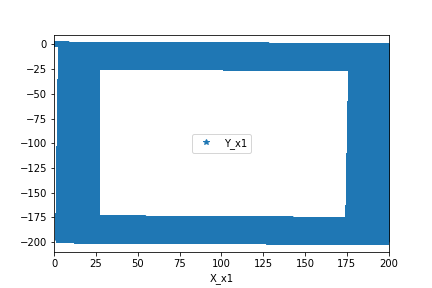

828
[b'\x01\x00\x00\x00@', b'!\x00\x00\x00A', b'P\xc3\x00\x00B', b'\x00\x00\x00\x00K', b'\xc82\xca\x0eL', b'\x8f\x88\x1a\xffM', b'\x00\x00\x00\x00S', b'\x00\x00\x00\x00T', b'\x00\x00\x00\x00U', b'\x80\xe5\xf9\xffZ', b'\x00\x00\x00\x00[', b'\x00\x00\x00\x00\\', b'\x00\x00\x00\x00]', b'\x0f\x1c\x1c\x1eC', b'\x01\x00\x00\x00\x81', b'\x9e\x07\x00\x00A', b'E\x93\n\x00J', b'\x00\x00\x00\x00L', b'\x00\x00\x00\x00M', b'\x0f\xe9\xff\xffR', b'\x05\x1e\x1e\x1eC', b'\x01\x00\x00\x00\x82', b'\x03\x00\x00\x00\x84', b'\x01\x00\x00\x00\x81', b'"\x00\x00\x00A', b'-\xcc\xf2\xf1L', b'\xa3\x99\xd3\x00M', b'\x02\xba/\xf2T', b'\x1e\x04\xd0\x00U', b'\x05\x1c\x1c\x1eC', b'\x01\x00\x00\x00\x82', b'\x03\x00\x00\x00\x84', b'\x01\x00\x00\x00\x81', b'\x8d\x07\x00\x00A', b'v\xe8\xff\xffJ', b'\x00\x00\x00\x00L', b'\x00\x00\x00\x00M', b'\xf7l\xf5\xffR', b'\x00\x00\x00\x00T', b'\x00\x00\x00\x00U', b'\x05\x1e\x1e\x1eC', b'\x01\x00\x00\x00\x82', b'\x03\x00\x00\x00\x84', b'\x01\x00\x00\x00\x81', b'"\x00\x00\x00A', b'X\x8

In [45]:
%matplotlib notebook
#steps_opt.plot(x = steps_opt["X_x"]/80, y = steps_opt["Y_x"]/80, style="*")

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
#steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
if 1:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

code = p.asg.gen_path_code(pr_opt)
print(len(code))
print(code)
            

In [5]:
path_deltas = []

for i in range(0, 20):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*100,      0, 50])
    path_deltas.append([       0, -k*100, 50])
    path_deltas.append([ -k2*100,      0, 50])
    path_deltas.append([       0, k2*100, 50])

path_deltas

[[200.0, 0, 50],
 [0, -200.0, 50],
 [-197.5, 0, 50],
 [0, 197.5, 50],
 [195.0, 0, 50],
 [0, -195.0, 50],
 [-192.5, 0, 50],
 [0, 192.5, 50],
 [190.0, 0, 50],
 [0, -190.0, 50],
 [-187.5, 0, 50],
 [0, 187.5, 50],
 [185.0, 0, 50],
 [0, -185.0, 50],
 [-182.5, 0, 50],
 [0, 182.5, 50],
 [180.0, 0, 50],
 [0, -180.0, 50],
 [-177.5, 0, 50],
 [0, 177.5, 50],
 [175.0, 0, 50],
 [0, -175.0, 50],
 [-172.5, 0, 50],
 [0, 172.5, 50],
 [170.0, 0, 50],
 [0, -170.0, 50],
 [-167.5, 0, 50],
 [0, 167.5, 50],
 [165.0, 0, 50],
 [0, -165.0, 50],
 [-162.5, 0, 50],
 [0, 162.5, 50],
 [160.0, 0, 50],
 [0, -160.0, 50],
 [-157.5, 0, 50],
 [0, 157.5, 50],
 [155.0, 0, 50],
 [0, -155.0, 50],
 [-152.5, 0, 50],
 [0, 152.5, 50],
 [150.0, 0, 50],
 [0, -150.0, 50],
 [-147.5, 0, 50],
 [0, 147.5, 50],
 [145.0, 0, 50],
 [0, -145.0, 50],
 [-142.49999999999997, 0, 50],
 [0, 142.49999999999997, 50],
 [140.0, 0, 50],
 [0, -140.0, 50],
 [-137.5, 0, 50],
 [0, 137.5, 50],
 [135.0, 0, 50],
 [0, -135.0, 50],
 [-132.5, 0, 50],
 [0, 132.5,